<a href="https://colab.research.google.com/github/Deepak-Mewada/NeuralDecoder/blob/main/BrainDecoder/Basics/plot_bcic_iv_4_ecog_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fingers flexion decoding on BCIC IV 4 ECoG Dataset

This tutorial shows you how to train and test deep learning models with
Braindecode on ECoG BCI IV competition dataset 4. For this dataset we will
predict 5 regression targets corresponding to flexion of each finger.
The targets were recorded as a time series (each 25 Hz), so this tutorial is
an example of time series target prediction.


In [4]:
!pip install braindecode
!pip install moabb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.8/563.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 22.4 MB/s eta 0:00:00
  Created wheel for pyriemann: filename=pyriemann-0.5-py2.py3-none-any.whl size=107752 sha256=bd5720d4abf14a2f3c578b6e7fa05037a6c03f21983d686a4eb735efb83fb710
  Stored in directory: /root/.cache/pip/wheels/84/86/79/622e9c1dc933dc088e287ebfaac5aa9bdc6a38a9db193ce1f1
Successfully built pyriemann
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninsta

## Loading and preparing the dataset




### Loading




First, we load the data. In this tutorial, we use the functionality of braindecode
to load [BCI IV competition dataset 4](http://www.bbci.de/competition/iv/#dataset4)_.
The dataset is available as a part of ECoG library:
https://searchworks.stanford.edu/view/zk881ps0522

The dataset contains ECoG signal and time series of 5 targets corresponding
to each finger flexion. This is different than standard decoding setup for EEG with
multiple trials and usually one target per trial. Here, fingers flexions change in time
and are recorded with sampling frequency equals to 25 Hz.

If this dataset is used please cite [1].

[1] Miller, Kai J. "A library of human electrocorticographic data and analyses.
"Nature human behaviour 3, no. 11 (2019): 1225-1235. https://doi.org/10.1038/s41562-019-0678-3



In [5]:
import numpy as np

from braindecode.datasets import BCICompetitionIVDataset4

subject_id = 1
dataset = BCICompetitionIVDataset4(subject_ids=[subject_id])

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


/usr/local/lib/python3.10/dist-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/usr/local/lib/python3.10/dist-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BCICOMPETITIONIVDATASET4_PATH"
  set_config(key, get_config("MNE_DATA"))
SHA256 hash of downloaded file: 04c237ab33f25eb11c93d4cea69693823693d16ef145d4a034a77ddae6238ebb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Creating RawArray with float64 data, n_channels=67, n_times=400000
    Range : 0 ... 399999 =      0.000 ...   399.999 secs
Ready.
Creating RawArray with float64 data, n_channels=67, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   199.999 secs
Ready.


### Preprocessing




Now we apply preprocessing like bandpass filtering to our dataset. You
can either apply functions provided by
[mne.Raw](https://mne.tools/stable/generated/mne.io.Raw.html)_ or
[mne.Epochs](https://mne.tools/0.11/generated/mne.Epochs.html#mne.Epochs)_
or apply your own functions, either to the MNE object or the underlying
numpy array.

<div class="alert alert-info"><h4>Note</h4><p>Preprocessing steps are taken from a standard EEG processing pipeline.
   The only change is the cutoff frequency of the filter. For a proper ECoG
   decoding other preprocessing steps may be needed.</p></div>

<div class="alert alert-info"><h4>Note</h4><p>These prepocessings are now directly applied to the loaded
   data, and not on-the-fly applied as transformations in
   PyTorch-libraries like
   [torchvision](https://pytorch.org/docs/stable/torchvision/index.html)_.</p></div>




In [6]:
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)

low_cut_hz = 1.
high_cut_hz = 200.

factor_new = 1e-3
init_block_size = 1000

We select only first 30 seconds from each dataset to limit time and memory
to run this example. To obtain results on the whole datasets you should remove this line.



In [7]:
preprocess(dataset, [Preprocessor('crop', tmin=0, tmax=30)])

In time series targets setup, targets variables are stored in mne.Raw object as channels
of type `misc`. Thus those channels have to be selected for further processing. However,
many mne functions ignore `misc` channels and perform operations only on data channels
(see https://mne.tools/stable/glossary.html#term-data-channels).



In [8]:
preprocessors = [
    Preprocessor('pick_types', ecog=True, misc=True),
    Preprocessor(lambda x: x / 1e6, picks='ecog'),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size, picks='ecog')
]

# Transform the data
preprocess(dataset, preprocessors)

# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Extract target sampling frequency
target_sfreq = dataset.datasets[0].raw.info['temp']['target_sfreq']

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



/usr/local/lib/python3.10/dist-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


### Cut Compute Windows




Now we cut out compute windows, the inputs for the deep networks during
training. In the case of trialwise decoding of time series targets, we just have to
decide about length windows that will be selected from the signal preceding each target.
We use different windowing function than in standard trialwise decoding as our targets
are stored as target channels in mne.Raw.



In [9]:
from braindecode.preprocessing import create_windows_from_target_channels

windows_dataset = create_windows_from_target_channels(
    dataset,
    window_size_samples=1000,
    preload=False,
    last_target_only=True
)

We select only the thumb's finger flexion to create one model per finger.

<div class="alert alert-info"><h4>Note</h4><p>Methods to predict all 5 fingers flexion with the same model may be cnosidered as well.
   We encourage you to find your own way to use braindecode models to predict finers fexions.</p></div>




In [10]:
windows_dataset.target_transform = lambda x: x[0: 1]

### Split dataset into train, valid, and test




We can easily split the dataset using additional info stored in the
description attribute, in this case ``session`` column. We select `train` dataset
for training and validation and `test` for final evaluation.



In [11]:
subsets = windows_dataset.split('session')
train_set = subsets['train']
test_set = subsets['test']

We can split train dataset into training and validation datasets using
``sklearn.model_selection.train_test_split`` and ``torch.utils.data.Subset``.



In [12]:
import torch
from sklearn.model_selection import train_test_split

idx_train, idx_valid = train_test_split(np.arange(len(train_set)),
                                        random_state=100,
                                        test_size=0.2,
                                        shuffle=False)

valid_set = torch.utils.data.Subset(train_set, idx_valid)
train_set = torch.utils.data.Subset(train_set, idx_train)

## Create model




Now we create the deep learning model! Braindecode comes with some
predefined convolutional neural network architectures for raw
time-domain EEG. Here, we use the shallow ConvNet model from [Deep
learning with convolutional neural networks for EEG decoding and
visualization](https://arxiv.org/abs/1703.05051)_. These models are
pure [PyTorch](https://pytorch.org)_ deep learning models, therefore
to use your own model, it just has to be a normal PyTorch
[nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module)_.



In [13]:
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_out_chans = train_set[0][1].shape[0]
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = 1000  # 1 second long windows

model = ShallowFBCSPNet(
    n_chans,
    n_out_chans,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    add_log_softmax=False,
)

# Send model to GPU
if cuda:
    model.cuda()

/usr/local/lib/python3.10/dist-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(


## Training




Now we train the network! EEGRegressor is a Braindecode object
responsible for managing the training of neural networks. It inherits
from skorch.NeuralNetRegressor, so the training logic is the same as in
[Skorch](https://skorch.readthedocs.io/en/stable/)_.

<div class="alert alert-info"><h4>Note</h4><p>In this tutorial, we use some default parameters that we
   have found to work well for EEG motor decoding, however we strongly
   encourage you to perform your own hyperparameter and preprocessing optimization using
   cross validation on your training data.</p></div>




In [14]:
from skorch.callbacks import EpochScoring, LRScheduler
from skorch.helper import predefined_split
from mne import set_log_level

from braindecode import EEGRegressor

# These values we found good for shallow network for EEG MI decoding:
lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 2


# Function to compute Pearson correlation coefficient
def pearson_r_score(net, dataset, y):
    preds = net.predict(dataset)
    corr_coeffs = []
    for i in range(y.shape[1]):
        corr_coeffs.append(np.corrcoef(y[:, i], preds[:, i])[0, 1])
    return np.mean(corr_coeffs)


regressor = EEGRegressor(
    model,
    criterion=torch.nn.MSELoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(valid_set),  # using valid_set for validation,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        'r2',
        ('valid_pearson_r', EpochScoring(pearson_r_score, lower_is_better=False, on_train=False,
                                         name='valid_pearson_r')),
        ('train_pearson_r', EpochScoring(pearson_r_score, lower_is_better=False, on_train=True,
                                         name='train_pearson_r')),
        ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
set_log_level(verbose='WARNING')

Model training for a specified number of epochs. ``y`` is None as it is already supplied
in the dataset.



In [15]:
regressor.fit(train_set, y=None, epochs=n_epochs)

  epoch    train_loss    train_pearson_r    train_r2    valid_loss    valid_pearson_r    valid_r2      lr      dur
-------  ------------  -----------------  ----------  ------------  -----------------  ----------  ------  -------
      1        2.5083             0.1251     -0.5582        5.7348            -0.1511     -1.6144  0.0006  34.1541
      2        1.7986             0.3712     -0.3157        5.2587            -0.1511     -1.3973  0.0000  20.8671


Obtaining predictions and targets for the test, train, and validation dataset



In [16]:
preds_test = regressor.predict(test_set)
y_test = np.stack([data[1] for data in test_set])
preds_train = regressor.predict(train_set)
y_train = np.stack([data[1] for data in train_set])
preds_valid = regressor.predict(valid_set)
y_valid = np.stack([data[1] for data in valid_set])

## Plot Results



We plot target and predicted finger flexion on training, validation, and test sets.

<div class="alert alert-info"><h4>Note</h4><p>The model is trained and validated on limited dataset (to decrease the time needed to run
   this example) which does not contain diverse dataset in terms of fingers flexions and may
   cause overfitting. To obtain better results use whole dataset as well as improve the decoding
   pipeline which may be not optimal for ECoG.</p></div>




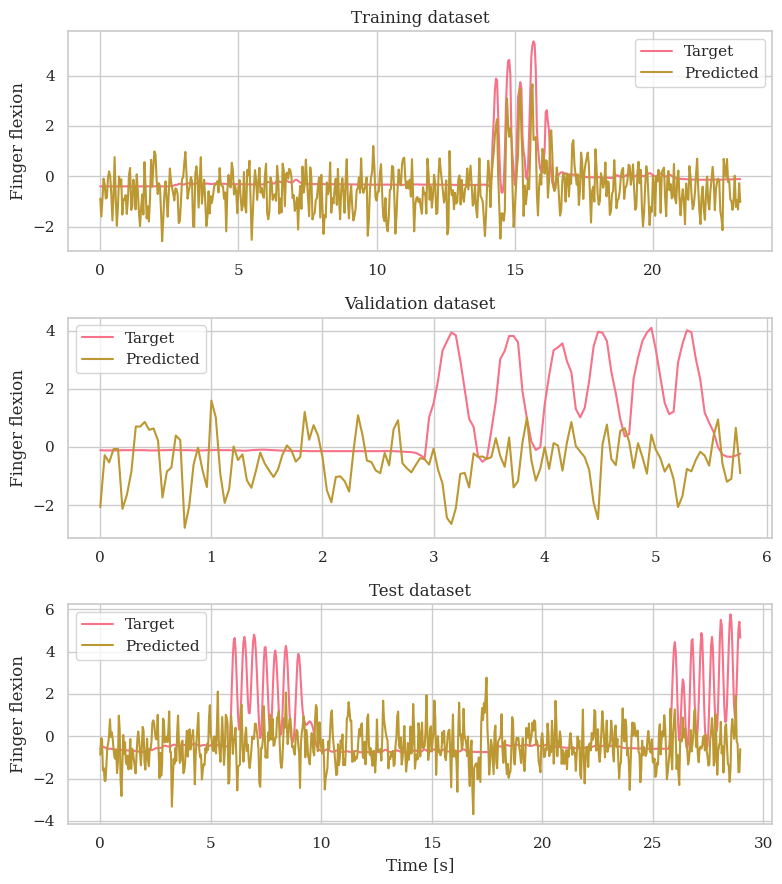

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

fig, axes = plt.subplots(3, 1, figsize=(8, 9))

axes[0].set_title('Training dataset')
axes[0].plot(np.arange(0, y_train.shape[0]) / target_sfreq, y_train[:, 0], label='Target')
axes[0].plot(np.arange(0, preds_train.shape[0]) / target_sfreq, preds_train[:, 0],
             label='Predicted')
axes[0].set_ylabel('Finger flexion')
axes[0].legend()

axes[1].set_title('Validation dataset')
axes[1].plot(np.arange(0, y_valid.shape[0]) / target_sfreq, y_valid[:, 0], label='Target')
axes[1].plot(np.arange(0, preds_valid.shape[0]) / target_sfreq, preds_valid[:, 0],
             label='Predicted')
axes[1].set_ylabel('Finger flexion')
axes[1].legend()

axes[2].set_title('Test dataset')
axes[2].plot(np.arange(0, y_test.shape[0]) / target_sfreq, y_test[:, 0], label='Target')
axes[2].plot(np.arange(0, preds_test.shape[0]) / target_sfreq, preds_test[:, 0], label='Predicted')
axes[2].set_xlabel('Time [s]')
axes[2].set_ylabel('Finger flexion')
axes[2].legend()
plt.tight_layout()

We can compute correlation coefficients for each finger




In [18]:
corr_coeffs = []
for dim in range(y_test.shape[1]):
    corr_coeffs.append(
        np.corrcoef(preds_test[:, dim], y_test[:, dim])[0, 1]
    )
print('Correlation coefficient for each dimension: ', np.round(corr_coeffs, 2))

Correlation coefficient for each dimension:  [0.1]


Now we use the history stored by Skorch throughout training to plot
accuracy and loss curves.
Extract loss and accuracy values for plotting from history object



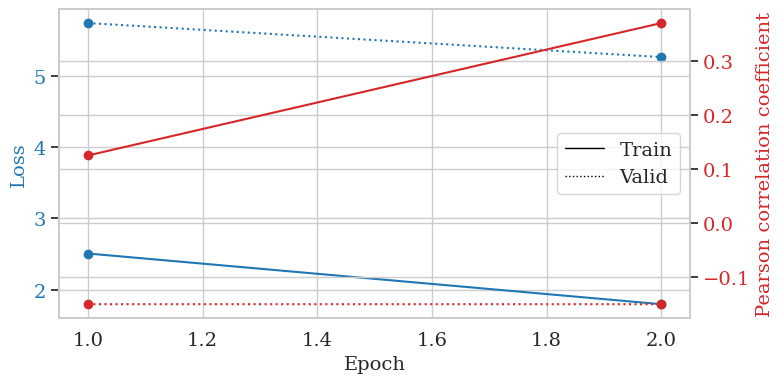

In [19]:
results_columns = ['train_loss', 'valid_loss', 'train_pearson_r', 'valid_pearson_r']
df = pd.DataFrame(regressor.history[:, results_columns], columns=results_columns,
                  index=regressor.history[:, 'epoch'])

fig, ax1 = plt.subplots(figsize=(8, 4))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_pearson_r', 'valid_pearson_r']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Pearson correlation coefficient", color='tab:red', fontsize=14)
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-',
                      label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':',
                      label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14, loc='center right')
plt.tight_layout()